# *(Gauthier, et. al, 2021)*: Next generation reservoir computing

Implementation of the paper:

- Gauthier, D.J., Bollt, E., Griffith, A. et al. Next generation reservoir
  computing. Nat Commun 12, 5564 (2021). https://doi.org/10.1038/s41467-021-25801-2

In [29]:
import matplotlib.pyplot as plt
import numpy as np

import brainpy as bp
import brainpy.math as bm
bm.enable_x64()

In [30]:
def plot_weights(Wout, coefs, bias=None):
  Wout = np.asarray(Wout)
  if bias is not None:
    bias = np.asarray(bias)
    Wout = np.concatenate([bias.reshape((1, 3)), Wout], axis=0)
    coefs.insert(0, 'bias')
  x_Wout, y_Wout, z_Wout = Wout[:, 0], Wout[:, 1], Wout[:, 2]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(131)
  ax.grid(axis="y")
  ax.set_xlabel("$[W_{out}]_x$")
  ax.set_ylabel("Features")
  ax.set_yticks(np.arange(len(coefs)))
  ax.set_yticklabels(coefs)
  ax.barh(np.arange(x_Wout.size), x_Wout)

  ax1 = fig.add_subplot(132)
  ax1.grid(axis="y")
  ax1.set_yticks(np.arange(len(coefs)))
  ax1.set_xlabel("$[W_{out}]_y$")
  ax1.barh(np.arange(y_Wout.size), y_Wout)

  ax2 = fig.add_subplot(133)
  ax2.grid(axis="y")
  ax2.set_yticks(np.arange(len(coefs)))
  ax2.set_xlabel("$[W_{out}]_z$")
  ax2.barh(np.arange(z_Wout.size), z_Wout)

  plt.show()

## Forecasting Lorenz63 strange attractor

In [31]:
def get_subset(data, start, end):
  res = {'x': data['x'][start: end],
         'y': data['y'][start: end],
         'z': data['z'][start: end]}
  res = bm.hstack([res['x'], res['y'], res['z']])
  return res.reshape((1, ) + res.shape)

In [32]:
def plot_lorenz(ground_truth, predictions):
  fig = plt.figure(figsize=(15, 10))
  ax = fig.add_subplot(121, projection='3d')
  ax.set_title("Generated attractor")
  ax.set_xlabel("$x$")
  ax.set_ylabel("$y$")
  ax.set_zlabel("$z$")
  ax.grid(False)
  ax.plot(predictions[:, 0], predictions[:, 1], predictions[:, 2])

  ax2 = fig.add_subplot(122, projection='3d')
  ax2.set_title("Real attractor")
  ax2.grid(False)
  ax2.plot(ground_truth[:, 0], ground_truth[:, 1], ground_truth[:, 2])
  plt.show()

In [33]:
dt = 0.01
t_warmup = 5.  # ms
t_train = 10.  # ms
t_test = 120.  # ms
num_warmup = int(t_warmup / dt)  # warm up NVAR
num_train = int(t_train / dt)
num_test = int(t_test / dt)


### Datasets

In [34]:
lorenz_series = bp.datasets.lorenz_series(t_warmup + t_train + t_test,
                                          dt=dt,
                                          inits={'x': 17.67715816276679,
                                                 'y': 12.931379185960404,
                                                 'z': 43.91404334248268})

X_warmup = get_subset(lorenz_series, 0, num_warmup - 1)
Y_warmup = get_subset(lorenz_series, 1, num_warmup)
X_train = get_subset(lorenz_series, num_warmup - 1, num_warmup + num_train - 1)
# Target: Lorenz[t] - Lorenz[t - 1]
dX_train = get_subset(lorenz_series, num_warmup, num_warmup + num_train) - X_train
X_test = get_subset(lorenz_series,
                    num_warmup + num_train - 1,
                    num_warmup + num_train + num_test - 1)
Y_test = get_subset(lorenz_series,
                    num_warmup + num_train,
                    num_warmup + num_train + num_test)

### Model

In [35]:
class NGRC(bp.dyn.DynamicalSystem):
  def __init__(self, num_in):
    super(NGRC, self).__init__()
    self.r = bp.layers.NVAR(num_in, delay=2, order=2, constant=True,)
    self.di = bp.layers.Dense(self.r.num_out, num_in, b_initializer=None)

  def update(self, sha, x):
    dx = self.di(sha, self.r(sha, x))
    return x + dx

In [36]:
model = NGRC(3)
print(model.r.get_feature_names())

['1', 'x0(t)', 'x1(t)', 'x2(t)', 'x0(t-1)', 'x1(t-1)', 'x2(t-1)', 'x0(t)^2', 'x0(t) x1(t)', 'x0(t) x2(t)', 'x0(t) x0(t-1)', 'x0(t) x1(t-1)', 'x0(t) x2(t-1)', 'x1(t)^2', 'x1(t) x2(t)', 'x1(t) x0(t-1)', 'x1(t) x1(t-1)', 'x1(t) x2(t-1)', 'x2(t)^2', 'x2(t) x0(t-1)', 'x2(t) x1(t-1)', 'x2(t) x2(t-1)', 'x0(t-1)^2', 'x0(t-1) x1(t-1)', 'x0(t-1) x2(t-1)', 'x1(t-1)^2', 'x1(t-1) x2(t-1)', 'x2(t-1)^2']


### Training

  0%|          | 0/499 [00:00<?, ?it/s]

Warmup NMS:  177831.03849871003


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

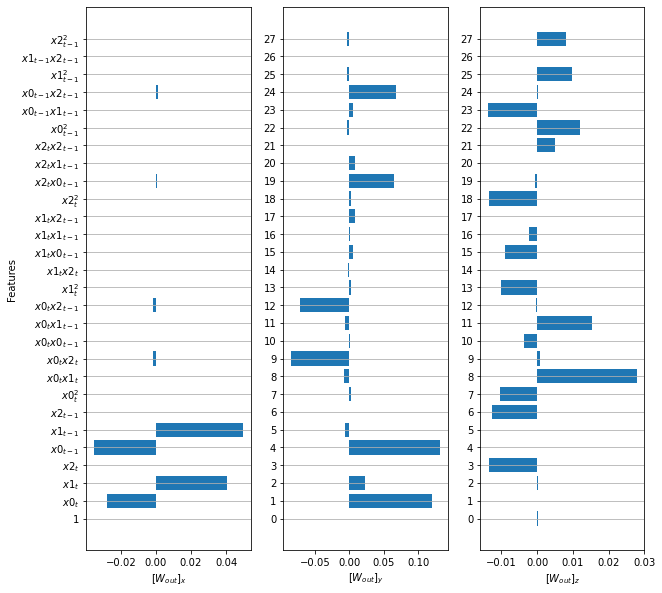

In [37]:
# warm-up
trainer = bp.train.RidgeTrainer(model, alpha=2.5e-6)

# training
outputs = trainer.predict(X_warmup)
print('Warmup NMS: ', bp.losses.mean_squared_error(outputs, Y_warmup))
trainer.fit([X_train, dX_train])
plot_weights(model.di.W, model.r.get_feature_names(for_plot=True), model.di.b)

### Prediction

Prediction NMS:  146.17665698159468


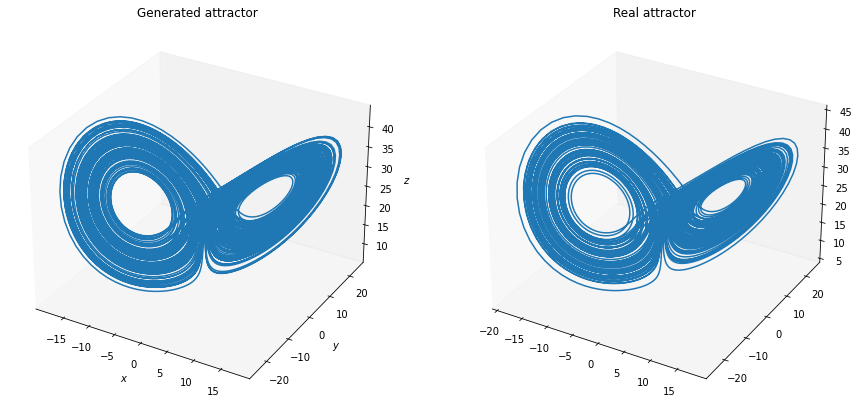

In [38]:
model = bm.jit(model)
outputs = [model(dict(), X_test[:, 0])]
for i in range(1, X_test.shape[1]):
  outputs.append(model(dict(), outputs[i - 1]))
outputs = bm.asarray(outputs)
print('Prediction NMS: ', bp.losses.mean_squared_error(outputs, Y_test))
plot_lorenz(Y_test.numpy().squeeze(), outputs.numpy().squeeze())

## Forecasting the double-scroll system

In [39]:
def plot_double_scroll(ground_truth, predictions):
  fig = plt.figure(figsize=(15, 10))
  ax = fig.add_subplot(121, projection='3d')
  ax.set_title("Generated attractor")
  ax.set_xlabel("$x$")
  ax.set_ylabel("$y$")
  ax.set_zlabel("$z$")
  ax.grid(False)
  ax.plot(predictions[:, 0], predictions[:, 1], predictions[:, 2])

  ax2 = fig.add_subplot(122, projection='3d')
  ax2.set_title("Real attractor")
  ax2.grid(False)
  ax2.plot(ground_truth[:, 0], ground_truth[:, 1], ground_truth[:, 2])
  plt.show()

In [40]:
dt = 0.02
t_warmup = 10.  # ms
t_train = 100.  # ms
t_test = 800.  # ms
num_warmup = int(t_warmup / dt)  # warm up NVAR
num_train = int(t_train / dt)
num_test = int(t_test / dt)

### Datasets

In [41]:
data_series = bp.datasets.double_scroll_series(t_warmup + t_train + t_test, dt=dt)

X_warmup = get_subset(data_series, 0, num_warmup - 1)
Y_warmup = get_subset(data_series, 1, num_warmup)
X_train = get_subset(data_series, num_warmup - 1, num_warmup + num_train - 1)
# Target: Lorenz[t] - Lorenz[t - 1]
dX_train = get_subset(data_series, num_warmup, num_warmup + num_train) - X_train
X_test = get_subset(data_series,
                    num_warmup + num_train - 1,
                    num_warmup + num_train + num_test - 1)
Y_test = get_subset(data_series,
                    num_warmup + num_train,
                    num_warmup + num_train + num_test)

### Model

In [42]:
class NGRC(bp.dyn.DynamicalSystem):
  def __init__(self, num_in):
    super(NGRC, self).__init__()
    self.r = bp.layers.NVAR(num_in, delay=2, order=3, mode=bp.modes.batching)
    self.di = bp.layers.Dense(self.r.num_out, num_in, mode=bp.modes.training)

  def update(self, sha, x):
    di = self.di(sha, self.r(sha, x))
    return x + di

model = NGRC(3)

### Training

In [43]:
# warm-up
trainer = bp.train.RidgeTrainer(model, alpha=1e-5, jit=True)

  0%|          | 0/499 [00:00<?, ?it/s]

Warmup NMS:  6.480980459174322


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

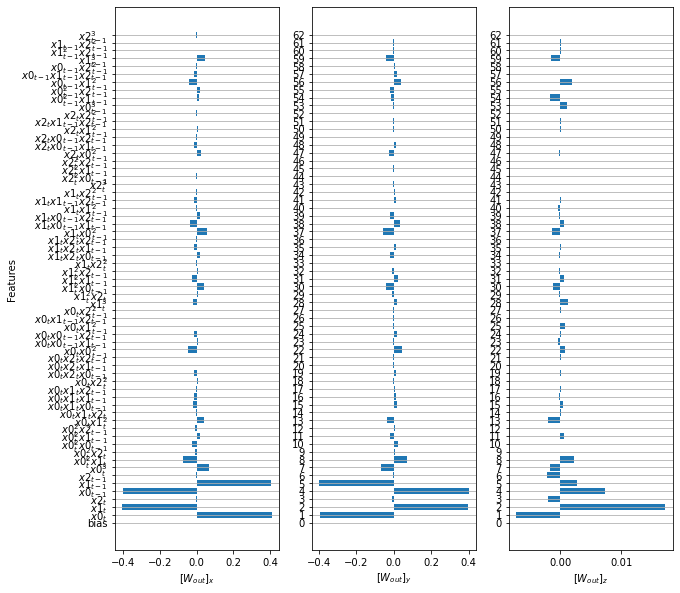

In [44]:
# training
outputs = trainer.predict(X_warmup)
print('Warmup NMS: ', bp.losses.mean_squared_error(outputs, Y_warmup))
trainer.fit([X_train, dX_train])
plot_weights(model.di.W, model.r.get_feature_names(for_plot=True), model.di.b)

### Prediction

Prediction NMS:  1.3086762853279683


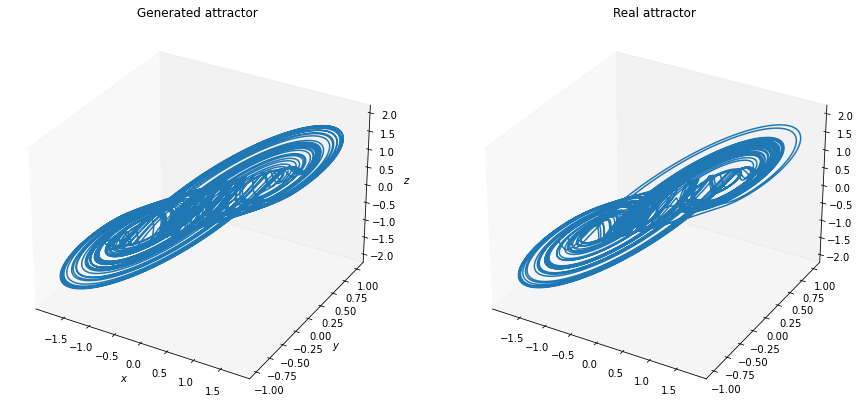

In [45]:
model = bm.jit(model)
outputs = [model(dict(), X_test[:, 0])]
for i in range(1, X_test.shape[1]):
  outputs.append(model(dict(), outputs[i - 1]))
outputs = bm.asarray(outputs).squeeze()
print('Prediction NMS: ', bp.losses.mean_squared_error(outputs, Y_test))
plot_double_scroll(Y_test.numpy().squeeze(), outputs.numpy())

## Infering dynamics of Lorenz63 strange attractor

In [46]:
def get_subset(data, start, end):
  res = {'x': data['x'][start: end],
         'y': data['y'][start: end],
         'z': data['z'][start: end]}
  X = bm.hstack([res['x'], res['y']])
  X = X.reshape((1,) + X.shape)
  Y = res['z']
  Y = Y.reshape((1, ) + Y.shape)
  return X, Y

In [47]:
def plot_lorenz2(x, y, true_z, predict_z, linewidth=.8):
  fig1 = plt.figure()
  fig1.set_figheight(8)
  fig1.set_figwidth(12)

  t_all = t_warmup + t_train + t_test
  ts = np.arange(0, t_all, dt)

  h = 240
  w = 2

  # top left of grid is 0,0
  axs1 = plt.subplot2grid(shape=(h, w), loc=(0, 0), colspan=2, rowspan=30)
  axs2 = plt.subplot2grid(shape=(h, w), loc=(36, 0), colspan=2, rowspan=30)
  axs3 = plt.subplot2grid(shape=(h, w), loc=(72, 0), colspan=2, rowspan=30)
  axs4 = plt.subplot2grid(shape=(h, w), loc=(132, 0), colspan=2, rowspan=30)
  axs5 = plt.subplot2grid(shape=(h, w), loc=(168, 0), colspan=2, rowspan=30)
  axs6 = plt.subplot2grid(shape=(h, w), loc=(204, 0), colspan=2, rowspan=30)

  # training phase x
  axs1.set_title('training phase')
  axs1.plot(ts[num_warmup:num_warmup + num_train],
            x[num_warmup:num_warmup + num_train],
            color='b', linewidth=linewidth)
  axs1.set_ylabel('x')
  axs1.axes.xaxis.set_ticklabels([])
  axs1.axes.set_xbound(t_warmup - .08, t_warmup + t_train + .05)
  axs1.axes.set_ybound(-21., 21.)
  axs1.text(-.14, .9, 'a)', ha='left', va='bottom', transform=axs1.transAxes)

  # training phase y
  axs2.plot(ts[num_warmup:num_warmup + num_train],
            y[num_warmup:num_warmup + num_train],
            color='b', linewidth=linewidth)
  axs2.set_ylabel('y')
  axs2.axes.xaxis.set_ticklabels([])
  axs2.axes.set_xbound(t_warmup - .08, t_warmup + t_train + .05)
  axs2.axes.set_ybound(-26., 26.)
  axs2.text(-.14, .9, 'b)', ha='left', va='bottom', transform=axs2.transAxes)

  # training phase z
  axs3.plot(ts[num_warmup:num_warmup + num_train],
            true_z[num_warmup:num_warmup + num_train],
            color='b', linewidth=linewidth)
  axs3.plot(ts[num_warmup:num_warmup + num_train],
            predict_z[num_warmup:num_warmup + num_train],
            color='r', linewidth=linewidth)
  axs3.set_ylabel('z')
  axs3.set_xlabel('time')
  axs3.axes.set_xbound(t_warmup - .08, t_warmup + t_train + .05)
  axs3.axes.set_ybound(3., 48.)
  axs3.text(-.14, .9, 'c)', ha='left', va='bottom', transform=axs3.transAxes)

  # testing phase x
  axs4.set_title('testing phase')
  axs4.plot(ts[num_warmup + num_train:num_warmup + num_train + num_test],
            x[num_warmup + num_train:num_warmup + num_train + num_test],
            color='b', linewidth=linewidth)
  axs4.set_ylabel('x')
  axs4.axes.xaxis.set_ticklabels([])
  axs4.axes.set_ybound(-21., 21.)
  axs4.axes.set_xbound(t_warmup + t_train - .5, t_all + .5)
  axs4.text(-.14, .9, 'd)', ha='left', va='bottom', transform=axs4.transAxes)

  # testing phase y
  axs5.plot(ts[num_warmup + num_train:num_warmup + num_train + num_test],
            y[num_warmup + num_train:num_warmup + num_train + num_test],
            color='b', linewidth=linewidth)
  axs5.set_ylabel('y')
  axs5.axes.xaxis.set_ticklabels([])
  axs5.axes.set_ybound(-26., 26.)
  axs5.axes.set_xbound(t_warmup + t_train - .5, t_all + .5)
  axs5.text(-.14, .9, 'e)', ha='left', va='bottom', transform=axs5.transAxes)

  # testing phose z
  axs6.plot(ts[num_warmup + num_train:num_warmup + num_train + num_test],
            true_z[num_warmup + num_train:num_warmup + num_train + num_test],
            color='b', linewidth=linewidth)
  axs6.plot(ts[num_warmup + num_train:num_warmup + num_train + num_test],
            predict_z[num_warmup + num_train:num_warmup + num_train + num_test],
            color='r', linewidth=linewidth)
  axs6.set_ylabel('z')
  axs6.set_xlabel('time')
  axs6.axes.set_ybound(3., 48.)
  axs6.axes.set_xbound(t_warmup + t_train - .5, t_all + .5)
  axs6.text(-.14, .9, 'f)', ha='left', va='bottom', transform=axs6.transAxes)

  plt.show()

In [48]:
dt = 0.02
t_warmup = 10.  # ms
t_train = 20.  # ms
t_test = 50.  # ms
num_warmup = int(t_warmup / dt)  # warm up NVAR
num_train = int(t_train / dt)
num_test = int(t_test / dt)

### Datasets

In [49]:
lorenz_series = bp.datasets.lorenz_series(t_warmup + t_train + t_test,
                                          dt=dt,
                                          inits={'x': 17.67715816276679,
                                                 'y': 12.931379185960404,
                                                 'z': 43.91404334248268})

X_warmup, Y_warmup = get_subset(lorenz_series, 0, num_warmup)
X_train, Y_train = get_subset(lorenz_series, num_warmup, num_warmup + num_train)
X_test, Y_test = get_subset(lorenz_series, 0, num_warmup + num_train + num_test)


### Model

In [50]:
class NGRC(bp.dyn.DynamicalSystem):
  def __init__(self, num_in):
    super(NGRC, self).__init__()
    self.r = bp.layers.NVAR(num_in, delay=4, order=2, stride=5, mode=bp.modes.batching)
    self.o = bp.layers.Dense(self.r.num_out, 1, mode=bp.modes.training)

  def update(self, sha, x):
    return self.o(sha, self.r(sha, x))


model = NGRC(2)

### Training

In [51]:
trainer = bp.train.RidgeTrainer(model, alpha=0.05)

# warm-up
outputs = trainer.predict(X_warmup)
print('Warmup NMS: ', bp.losses.mean_squared_error(outputs, Y_warmup))

# training
trainer.fit([X_train, Y_train])

  0%|          | 0/500 [00:00<?, ?it/s]

Warmup NMS:  7641.092680049746


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

JaxArray([[[   3.12780367],
           [ -29.40258195],
           [ -73.02500095],
           [-121.30392143],
           [-164.91025258],
           [-192.33766731],
           [-194.93362579],
           [-172.49600696],
           [-133.92240591],
           [ -91.96391372],
           [ -56.65999294],
           [ -32.36533459],
           [ -18.81488058],
           [ -13.4006271 ],
           [ -12.72920904],
           [ -13.61132457],
           [ -13.88768438],
           [ -12.78482164],
           [ -10.58590304],
           [  -7.98292666],
           [  -5.58309291],
           [  -3.72612184],
           [  -2.51519077],
           [  -1.92075509],
           [  -1.87516767],
           [  -2.33434571],
           [  -3.31169349],
           [  -4.89665989],
           [  -7.26766007],
           [ -10.70306864],
           [ -15.58579238],
           [ -22.38443617],
           [ -31.57367824],
           [ -43.42694863],
           [ -57.58873182],
           [ -72.365

### Prediction

In [53]:
outputs = trainer.predict(X_test, reset_state=True)
print('Prediction NMS: ', bp.losses.mean_squared_error(outputs, Y_test))

  0%|          | 0/4000 [00:00<?, ?it/s]

Prediction NMS:  590.5516827412605


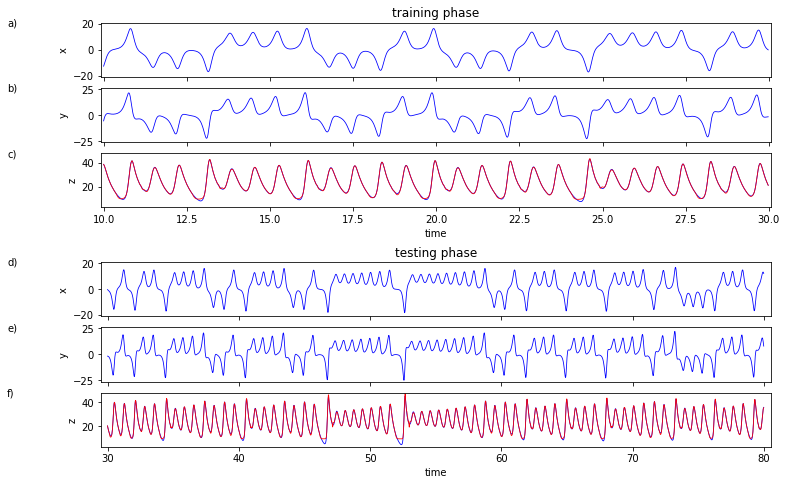

In [55]:
plot_lorenz2(x=bm.as_numpy(lorenz_series['x'].flatten()),
             y=bm.as_numpy(lorenz_series['y'].flatten()),
             true_z=bm.as_numpy(lorenz_series['z'].flatten()),
             predict_z=bm.as_numpy(outputs.flatten()))